## init

In [4]:
# import sys 
# sys.path.append('pyfiles/')

from pyfiles import (parametrics as par,
    complex as cplx,
    matrix as mat,
    vineyard as vin,
    input as inp,
    plot as ourplot
)

# so we don't have to reboot kernel every time we modify classes.py
%load_ext autoreload
%autoreload 2

# math stuff
import numpy as np
import math
# visualization
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.ndimage import gaussian_filter1d
from scipy.spatial import distance
from scipy.stats import qmc
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline

import csv
import string

# for polygon grid
from matplotlib.path import Path as mplPath

######## NOTE: from this point on, order is important. 
# it would be good to make the code more robust, but right
# now, there are ordered dependencies between functions.

## this is the new, streamlined thing

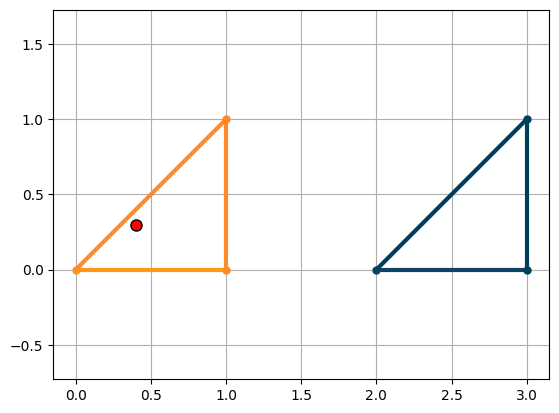

In [10]:
# read in .obj file
our_complex = inp.read_obj("input/two_triangles.obj")


# set the key point from which we measure radial dist
our_complex.key_point = (.4, .3)
# sort
distlist = cplx.augment_with_radialdist(our_complex)
our_complex.sort_by_dist(distlist)

# plot the complex with a heatmap from the key point
ourplot.plot_complex(our_complex)

matrix = mat.bdmatrix()
# matrix.initmatrix = np.array(
#             [
#                 [0, 1, 1, 1, 0, 0, 0],
#                 [0, 0, 0, 0, 1, 0, 1],
#                 [0, 0, 0, 0, 1, 1, 0],
#                 [0, 0, 0, 0, 0, 1, 1],
#                 [0, 0, 0, 0, 0, 0, 0],
#                 [0, 0, 0, 0, 0, 0, 0],
#                 [0, 0, 0, 0, 0, 0, 0],
#             ]
#         )
matrix.make_matrix(our_complex)


In [28]:
# with ourplot.PandasMatrix(matrix) as p:
#      matrix.reduce(every_step=p.every_step)
reduced = matrix.reduce()